In [1]:
#Dependancies

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model

# Reflect Database into ORM classes
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
#This double checks the tables using a separate method
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB

# Create a database session object
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [9]:
#Measurements Table
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#Stations Table
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Calculate the date 1 year ago from the last data point in the database

final_date_from_data = session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).first()
final_date_from_data

('2017-08-23')

In [12]:
unpacked_final, =final_date_from_data
final_year = int(unpacked_final[:4])
final_month = int(unpacked_final[6:7])
final_day = int(unpacked_final[8:])
year_before_end_date = dt.date(final_year,final_month,final_day) - dt.timedelta(days = 366)
year_before_end_date

datetime.date(2016, 8, 22)

In [13]:
# Perform a query to retrieve the data and precipitation scores - for the last year of the data
results1 = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).filter(Measurement.date > year_before_end_date).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results1, columns=['Date', 'Precipitation'])

In [15]:
# Sort the dataframe by date
precipitation_df.set_index('Date', inplace=True)

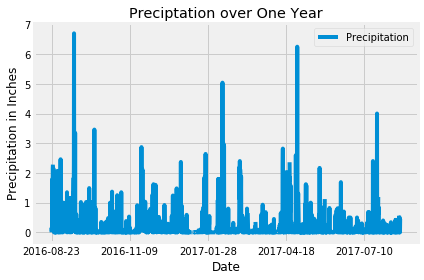

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
# Plot the Results in a Matplotlib bar chart
precipitation_df.plot.line()
plt.title('Preciptation over One Year')
plt.ylabel('Precipitation in Inches')
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data - for the last year of data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data - for all of the data

# Perform a query to retrieve the data and precipitation scores - for the last year of the data
results2 = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df2 = pd.DataFrame(results2, columns=['Date', 'Precipitation'])
#summary statistics
precipitation_df2.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [19]:
# Design a query to show how many stations are available in this dataset
results3 = session.query(Measurement.station).distinct().all()
print(f"Number of stations in the dataset: {len(results3)}")

Number of stations in the dataset: 9


In [20]:
# List the stations and the counts in descending order.
results4 = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
results4

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
results5 = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

#This unpacks the tuple to just have a string with the Station
Most_active, = results5
Most_active

'USC00519281'

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
Most_activate_info = session.query(*sel).filter(Measurement.station == Most_active).all()
station, min_temp, max_temp, avg_temp = Most_activate_info[0]
print(f"Station {station} is the most active station. The lowester temperature recorded there is {min_temp}. The highest temperature recorded there is {max_temp}. The average temperature is {avg_temp}.")

Station USC00519281 is the most active station. The lowester temperature recorded there is 54.0. The highest temperature recorded there is 85.0. The average temperature is 71.66378066378067.


In [23]:
# Choose the station with the highest number of temperature observations.
results7 = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

#This unpacks the tuple to just have a string with the Station
Most_temp_obs, = results7
Most_temp_obs

'USC00519281'

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results8 = session.query(Measurement.date, Measurement.tobs).order_by(Measurement.date).filter(Measurement.date > year_before_end_date).filter(Measurement.station == Most_temp_obs).all()

In [25]:
# Save the query results as a Pandas DataFrame and set the index to the date column
temperature_df = pd.DataFrame(results8, columns=['Date', 'Temperature'])

In [26]:
# Sort the dataframe by date
temperature_df.set_index('Date', inplace=True)

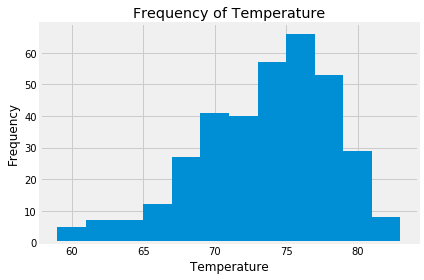

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data histogram
temp_ob_list = temperature_df['Temperature'].to_numpy()

plt.hist(temp_ob_list, bins=12)
plt.title('Frequency of Temperature')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.tight_layout()
plt.show()

In [28]:
session.close()

## Climate App

In [29]:
#Please see the file called "app.py" that is also in this folder for the Climate App portion of the assignment